<a href="https://colab.research.google.com/github/NatalyaEvans/Iodine_Frontiers/blob/main/pyompa/ETNP_pyompa_for_iodine_full_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script first performs an eOMP on the ETNP ODZ data from the WOD18 usung the core endmembers. Next, it generates a range of potential endmember nutrient concentrations, based on remineralization stoichiometry, and performs eOMP on all of them too. These calculations are performed because the nitrate anaerobic slope is sensitive to endmember nutrient concentrations. 

To do:
Comment the shit out of this
Load files in from github instead of drive
Load in sensitivity code from github instead of just pasting it in here


Mount the google drive folder


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install pyompa and gsw

In [2]:
!pip install pyompa==0.4.2.0
!pip install gsw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyompa: filename=pyompa-0.4.2.0-py3-none-any.whl size=27944 sha256=bff7198eab1a229d96ee5a0392a03a4db3b9b29149f735e1f5fc254c732245d7
  Stored in directory: /root/.cache/pip/wheels/ee/bf/52/4e3078948c0fc6eacfffc76536a754087fb12697781430ecec
Successfully built pyompa
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 5.1 MB/s 


In [3]:
%cd "/content/drive/MyDrive/pyompa/FK180624 for iodine pyompa"
!ls

/content/drive/MyDrive/pyompa/FK180624 for iodine pyompa
 ETNP_df_ompasoln.csv
 ETNP_pyompa_for_iodine_full_version.ipynb
 ETNP_pyompa_ref_values.csv
'File description.docx'
 FK180624_1mbinned_most.csv
 FK_ompa_04no3.csv
 Talia_ETNP_pyompa_for_iodine_ENPCW.ipynb
 Talia_ETNP_pyompa_for_iodine_uPSUW.ipynb



Load the input data

In [4]:
import scipy.io
from scipy.io import loadmat
import pandas as pd
import numpy as np
import json
from collections import OrderedDict


In [12]:
inp_df = pd.read_csv("FK_ompa_04no3.csv")
#inp_df.columns

#Filter the data frame to density ranges used for intermedite waters
data_df = pd.DataFrame(
   inp_df[(inp_df["pdens"] >= 26.4)
              & (inp_df["pdens"] <= 27.2)])

data_df.columns

Index(['ID', 'STNNBR', 'CASTNO', 'SAMPNO', 'DATE', 'TIME', 'lat', 'long',
       'press', 'O2', 'FLOR', 'NOx', 'NOx_STD', 'NO2', 'PO4', 'NH4', 'PH_TOT',
       'Iodate', 'Iodide', 'Total_I', 'NO3', 'Abs sal', 'Consv temp', 'pdens'],
      dtype='object')

Define the end-members. Column headers here have to match those of the observations pandas

In [13]:
endmembers_df_read = pd.read_csv("ETNP_pyompa_ref_values.csv")

In [14]:
endmembers_df_read.head()

,Water masses,Consv temp,Abs sal,PO4,NO3,Silicate,tCO2,pdens,Notes
0,13CW,13.410,34.95,2.355,31.20,25.40,2247,26.29,Adjusted to a more centered point in intersection
1,NEPIW,9.470,34.78,2.650,35.60,33.86,2270,26.74,NaN
2,AAIW,5.530,34.70,3.130,43.21,83.68,2323,27.25,"Shifted to on the intersection, rather than th..."
3,uPSUW,7.765,32.96,1.130,10.07,11.40,2235,25.60,NaN


Remove the non-water types from the endmembers

In [15]:
endmembers_df = endmembers_df_read.iloc[[0,1,2]] # use uPSUW or no fourth

display(endmembers_df.head)

<bound method NDFrame.head of   Water masses  Consv temp  Abs sal    PO4    NO3  Silicate  tCO2  pdens  \
0         13CW       13.41    34.95  2.355  31.20     25.40  2247  26.29   
1        NEPIW        9.47    34.78  2.650  35.60     33.86  2270  26.74   
2         AAIW        5.53    34.70  3.130  43.21     83.68  2323  27.25   

                                               Notes  
0  Adjusted to a more centered point in intersection  
1                                                NaN  
2  Shifted to on the intersection, rather than th...  >

Define the pyompa parameters to replicate the matlab OMP analysis, and run the analysis

In [16]:
import pyompa
from pyompa.endmemberpenaltyfunc import GeneralPenaltyFunc

#Define a parameter to represent remineralization in terms of phosphate
# The ratio of oxygen:phosphate specified is -170:1, that is 170 moles of
# oxygen consumed for each mole of oxygen produced.
convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="aerobic_remin",
        conversion_ratios=[{"PO4": 1.0, "NO3": 15},
        {"PO4": 1.0, "NO3": 17}],
        always_positive=False 
        ),pyompa.ConvertedParamGroup(
        groupname="anaerobic_remin",
        conversion_ratios=[{"PO4": 1.0, "NO3": -40},
        {"PO4": 1.0, "NO3": -65}],
        always_positive=True 
        )
]

usage_penalty = { 
    "AAIW": GeneralPenaltyFunc(
        spec={
            'pdens':
            # {'type':'exp_density_default', 'lowerbound':26.7}})
            {'type':'exp_other',"alpha":0.03, "beta":50, 'lowerbound':26.7}})}

paramweightings = {
    "Consv temp": 12.0,
    "Abs sal": 8.0,
    "PO4": 6.0,
    "NO3": 4.0,
}

settings = {
    "param_names": ["Consv temp", "Abs sal",
                    "PO4", "NO3"],
    "param_weightings": paramweightings,
    "convertedparam_groups": convertedparamgroups,
    #setting sumtooneconstraint to False replicates the behavior of the
    # MATLAB OMP implementation, which does not enforce mass conservation.
    # By default, sumtooneconstraint is True in pyompa.
    "sumtooneconstraint": True,
    #standardize_by_watertypes=True replicates the normalization behavior
    # of the MATLAB OMP implementation. By default, this is False.
    "standardize_by_watertypes": False
}

#Run the analysis, replicating the MATLAB OMP analysis
ETNP_df_ompasoln = pyompa.OMPAProblem(
  obs_df = data_df,
  endmembername_to_usagepenaltyfunc=usage_penalty,
  **settings).solve(
      endmembers_df,
      endmember_name_column="Water masses")
  
# ** notation uses a python dictionary and maps the keys in that dict to the parameter names, shorthand parameter specs nto a dictionary

Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['Consv temp', 'Abs sal', 'PO4', 'NO3']
param weighting: [12.  8.  6.  4.]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 214 out of 214
status: optimal
optimal value 16.51239447323815
Original weighted sum squares: 16.269662686965617
Post fix weighted sum squared: 16.270981892506896
Trying convertedvariable sign constraint: [-1 -1  1  1]
On example 0 to 214 out of 214
status: optimal
optimal value 698.490356719472
Original weighted sum squares: 698.1469376474913
Post fix weighted sum squared: 698.1580999629218
On example 0 to 214 out of 214
status: optimal
optimal value 6.860386210979993
Original weighted sum squares: 6.567188224761072
Post fix weighted sum squared: 6.567221410585015
objective: 6.567221410585015



Load in plotting tools

In [17]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

Plot results

Water mass fractions and deltaP


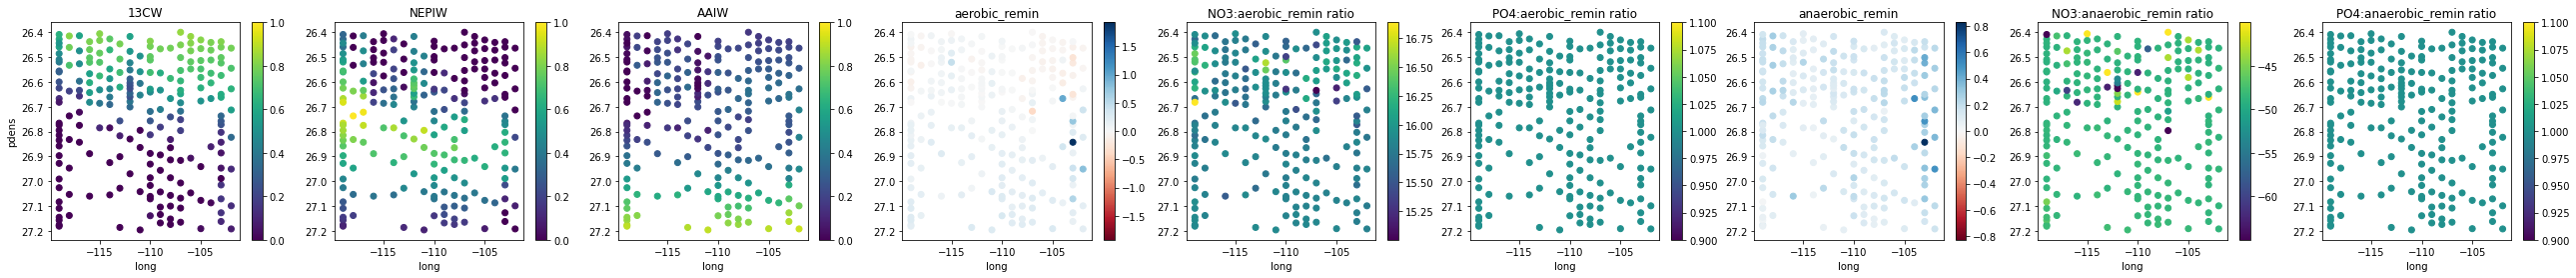

In [18]:
xaxis_colname="long"
yaxis_colname = "pdens"
print("Water mass fractions and deltaP")
plot_ompasoln_endmember_fractions(ompa_soln=ETNP_df_ompasoln,
                                  xaxis_colname=xaxis_colname,
                                  yaxis_colname=yaxis_colname)


Plot residuals

Residuals


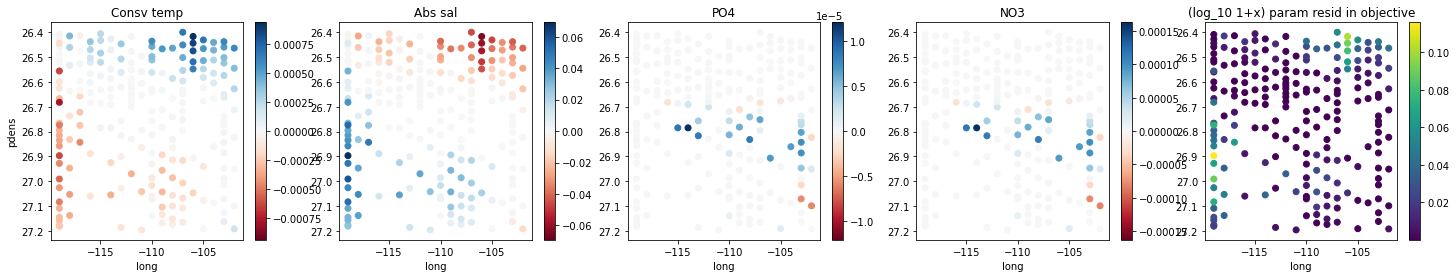

In [19]:
print("Residuals")
plot_ompasoln_residuals(ompa_soln=ETNP_df_ompasoln,
                        xaxis_colname=xaxis_colname,
                        yaxis_colname=yaxis_colname)

Output the pyompa sol'n




In [20]:
# ORIG_COLS_TO_INCLUDE = ["lat", "long", "pdens", "pressure", "nitrate", "oxygen", "phosphate",'conservative_temp', 'absolute_salinity']
ORIG_COLS_TO_INCLUDE = list(data_df.columns.values)
ETNP_df_ompasoln.export_to_csv(
    csv_output_name="ETNP_df_ompasoln.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)


writing to ETNP_df_ompasoln.csv


Starting sensitivity analysis
Don't forget to ask Avanti how to put this file into my github for the paper!

In [33]:
#Install gp15wmascripts
!pip uninstall -y gp15wma
%cd /content/
!rm -rf gp15wmascripts
!git clone https://github.com/nitrogenlab/gp15wmascripts
%cd /content/gp15wmascripts
!git checkout main
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import gp15wma
reload(gp15wma)

Found existing installation: gp15wma 0.1.0.0
Uninstalling gp15wma-0.1.0.0:
  Successfully uninstalled gp15wma-0.1.0.0
/content
Cloning into 'gp15wmascripts'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 248 (delta 13), reused 3 (delta 3), pack-reused 226
Receiving objects: 100% (248/248), 16.42 MiB | 21.81 MiB/s, done.
Resolving deltas: 100% (137/137), done.
/content/gp15wmascripts
Already on 'main'
Your branch is up to date with 'origin/main'.
commit 0f8be9e53d4dfdb510bd26abfe98a12fce38a942 (HEAD -> main, origin/main, origin/HEAD)
Author: rml54 <45828236+rml54@users.noreply.github.com>
Date:   Mon Apr 18 17:02:17 2022 -0400

    Update funcdump.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/gp15wmascripts
  DEPRECATION: A future pip version will change local packages to be built in-place without first copyi

/content


<module 'gp15wma' from '/usr/local/lib/python3.7/dist-packages/gp15wma/__init__.py'>

In [22]:
from gp15wma.sensitivity import BaseSensitivityAnalysis, OmpaArguments

from gp15wma.sensitivity import get_mean_and_stdev_skeletons


In [24]:
def plot_ompasoln_residuals2(ompa_soln, xaxis_colname,
                             yaxis_colname, flip_y=True):
  pyompa.plotting.plot_residuals(
          param_residuals=ompa_soln.param_residuals,
          param_names=ompa_soln.param_names,
          xaxis_vals=ompa_soln.obs_df[xaxis_colname],
          xaxis_label=xaxis_colname,
          yaxis_vals=ompa_soln.obs_df[yaxis_colname],
          yaxis_label=yaxis_colname, flip_y=flip_y,
          perobs_weighted_resid_sq=None)



In [ ]:
# #Install endmember sensitivities

# !pip uninstall -y ETNP_stoich
# %cd /content/
# !rm -rf ETNP_stoich
# !git clone https://github.com/NatalyaEvans/ETNP_stoich/
# %cd /content/ETNP_stoich
# !git checkout main
# !git log -1
# !pip install .
# %cd /content/

# %reload_ext autoreload
# %autoreload 2
# from importlib import reload
# import pyompa_scripts
# reload(pyompa_scripts)

In [30]:
def perturb_endmember_df(df, variation_range, rng):
  new_df = OrderedDict([
      ("Water masses", df["Water masses"]) #endmember name column
  ])
  params_to_perturb = ["Consv temp", "Abs sal", "PO4", "NO3"]
  for param_name in params_to_perturb:
    values = list(df[param_name])
    new_values = [rng.uniform(value-variation_range[param_name],
                              value+variation_range[param_name])
                  for value in values]
    new_df[param_name] = new_values

  return pd.DataFrame(new_df)


def perturb_endmember_df_stoichiometrically(df, stoichiometry, rng,
                                            perturbation_limits_0, 
                                            scale_factor):
  #in Talia's project, pertubation_limits corresponds to phosphate which
  # has ratio 1 wrt to the converted param
  
  new_df = OrderedDict([
      ("Water masses", df["Water masses"]), #endmember name column and params that are carried through
      ("Consv temp", df["Consv temp"]),
      ("Abs sal", df["Abs sal"]),
  ])

  params_to_perturb = ["PO4", "NO3"]

  # print(sampled_perturbations)
  for param_name in params_to_perturb:
    values = list(df[param_name])

    # sample a different perturbation for each row in the data frame
    sampled_perturbations_0 = [rng.uniform(perturbation_limits_0[0], # remin 1
                                    perturbation_limits_0[1])
                              for i in range(len(df))]
    sampled_perturbations_1 = [rng.uniform(perturbation_limits_0[0]*scale_factor, # remin 2
                                       perturbation_limits_0[1]*scale_factor)
                                for i in range(len(df))]

    new_values = [value + sampled_perturbation0*(stoichiometry[0].conversion_ratios[0][param_name] +
                        stoichiometry[0].conversion_ratios[1][param_name])/2
                        for sampled_perturbation0, value in
                        zip(sampled_perturbations_0, values)]
                  
    new_values2 = [value + sampled_perturbation1*(stoichiometry[1].conversion_ratios[0][param_name] +
                        stoichiometry[1].conversion_ratios[1][param_name])/2
                        for sampled_perturbation1, value in
                        zip(sampled_perturbations_1, new_values)]

    new_df[param_name] = new_values2


  return pd.DataFrame(new_df)

# perturb_endmember_df_stoichiometrically(
#     endmembers_df,
#     stoichiometry=convertedparamgroups, # now inputting the whole thing
#     perturbation_limits_0=(-0.15, 0.15),
#     scale_factor=0.1/0.15,
#     rng = np.random.RandomState(1234))

Sensitivity with regards to endmembers

In [35]:
#Prepare the varying OMPA arguments

rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 10
base_endmembers = endmembers_df

#sample varying parameter weightings
sampled_endmembers = []
for i in range(num_samples):
    sampled_endmembers.append(perturb_endmember_df_stoichiometrically(
    endmembers_df,
    # stoichiometry=convertedparamgroups[0].conversion_ratios[1],
    stoichiometry=convertedparamgroups,
    perturbation_limits_0=(-0.075, 0.075),
    scale_factor=1/3,
    rng=rng))
    print("Iteration:", i)
    display(sampled_endmembers[-1])

##write out the various sampled weightings
#open("sampled_endmembers.json", "w").write(
#    json.dumps(sampled_endmembers, indent=4))

varying_arguments_list = [OmpaArguments(
        constructor_arguments={},
        solve_arguments={"endmember_df": df}) for df in sampled_endmembers]

ETNP_weighting_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "param_weightings": paramweightings,
          "obs_df": ETNP_df_ompasoln.obs_df,
          "endmembername_to_usagepenaltyfunc": usage_penalty,
          "param_names": ETNP_df_ompasoln.param_names,
          "convertedparam_groups": convertedparamgroups
          },
        solve_arguments={
            "endmember_name_column": "Water masses",
            "batch_size": 100
        }
    ))

!mkdir endmembers_sensitivity
ompa_solns = ETNP_weighting_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="endmembers_sensitivity",
    export_settings={"orig_cols_to_include":ORIG_COLS_TO_INCLUDE})

Iteration: 0


,Water masses,Consv temp,Abs sal,PO4,NO3
0,13CW,13.41,34.95,2.322996,29.676691
1,NEPIW,9.47,34.78,2.682315,36.697723
2,AAIW,5.53,34.70,3.109289,44.306922


Iteration: 1


,Water masses,Consv temp,Abs sal,PO4,NO3
0,13CW,13.41,34.95,2.385579,31.551869
1,NEPIW,9.47,34.78,2.682059,37.632963
2,AAIW,5.53,34.70,3.086226,43.230063


Iteration: 2


,Water masses,Consv temp,Abs sal,PO4,NO3
0,13CW,13.41,34.95,2.434408,33.021018
1,NEPIW,9.47,34.78,2.663549,34.910631
2,AAIW,5.53,34.70,3.117985,43.398128


Iteration: 3


,Water masses,Consv temp,Abs sal,PO4,NO3
0,13CW,13.41,34.95,2.333285,30.026213
1,NEPIW,9.47,34.78,2.691721,37.218489
2,AAIW,5.53,34.70,3.105535,43.275838


Iteration: 4


,Water masses,Consv temp,Abs sal,PO4,NO3
0,13CW,13.41,34.95,2.334810,30.190146
1,NEPIW,9.47,34.78,2.653742,35.384740
2,AAIW,5.53,34.70,3.047122,43.140852


Iteration: 5


,Water masses,Consv temp,Abs sal,PO4,NO3
0,13CW,13.41,34.95,2.307571,32.083081
1,NEPIW,9.47,34.78,2.662853,36.130688
2,AAIW,5.53,34.70,3.104408,42.078290


Iteration: 6


,Water masses,Consv temp,Abs sal,PO4,NO3
0,13CW,13.41,34.95,2.370743,29.720509
1,NEPIW,9.47,34.78,2.586907,34.023770
2,AAIW,5.53,34.70,3.091175,42.728485


Iteration: 7


,Water masses,Consv temp,Abs sal,PO4,NO3
0,13CW,13.41,34.95,2.402450,29.181174
1,NEPIW,9.47,34.78,2.604161,35.815740
2,AAIW,5.53,34.70,3.163825,43.271019


Iteration: 8


,Water masses,Consv temp,Abs sal,PO4,NO3
0,13CW,13.41,34.95,2.369003,32.838694
1,NEPIW,9.47,34.78,2.711236,36.973303
2,AAIW,5.53,34.70,3.073973,44.081537


Iteration: 9


,Water masses,Consv temp,Abs sal,PO4,NO3
0,13CW,13.41,34.95,2.281791,32.942971
1,NEPIW,9.47,34.78,2.715512,33.951563
2,AAIW,5.53,34.70,3.124876,42.303085


mkdir: cannot create directory ‘endmembers_sensitivity’: File exists
On varying argument 0 out of 10
varying arguments: OMPAArguments(constructor_arguments={}, solve_arguments={'endmember_df':   Water masses  Consv temp  Abs sal       PO4        NO3
0         13CW       13.41    34.95  2.322996  29.676691
1        NEPIW        9.47    34.78  2.682315  36.697723
2         AAIW        5.53    34.70  3.109289  44.306922})
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['Consv temp', 'Abs sal', 'PO4', 'NO3']
param weighting: [12.  8.  6.  4.]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 100 out of 214
status: optimal
optimal value 13.331668635236957
Original weighted sum squares: 13.175851689729411
Post fix weighted sum squared: 13.177319939418348
On example 100 to 200 out of 214
status: optimal
optimal value 3.086294548295891
Original weighted sum squares: 2.9659534326820296
Post

mean


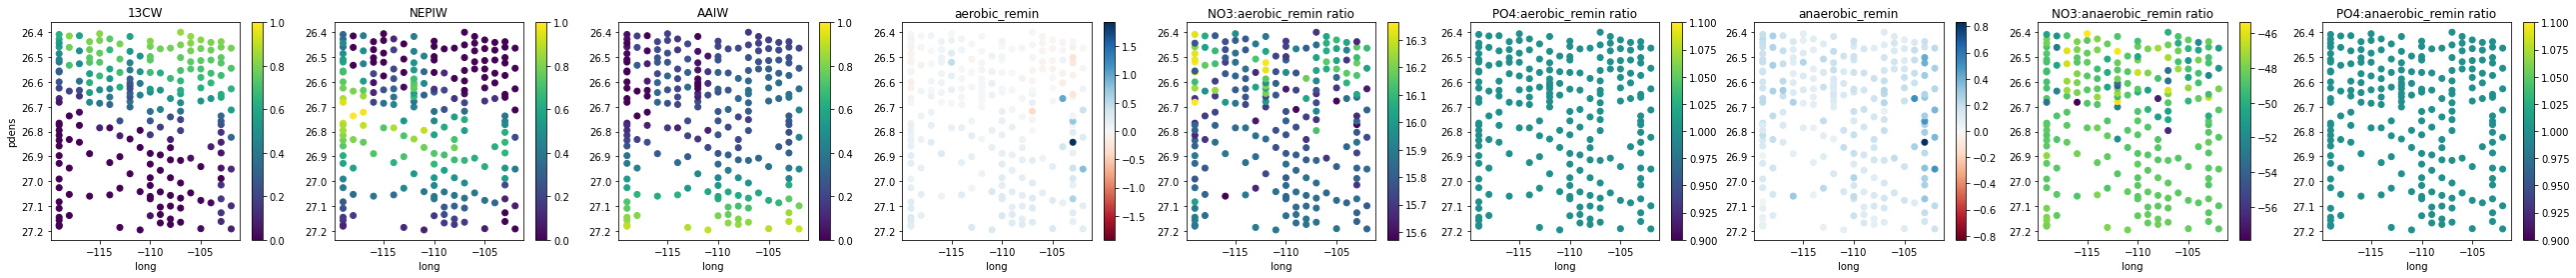

std


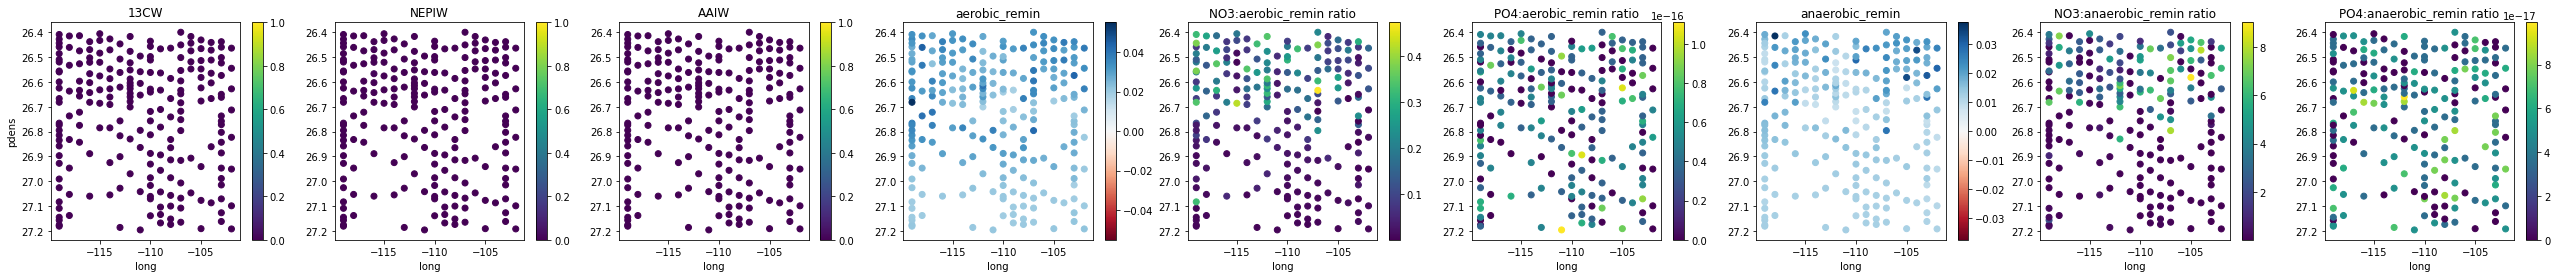

In [38]:
#plot the solutions

mean_skeleton_endmembers, std_skeleton_endmembers = get_mean_and_stdev_skeletons(ompa_solns=ompa_solns)

print("mean")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=mean_skeleton_endmembers,
                                  xaxis_colname="long",
                                  yaxis_colname="pdens")
print("std")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=std_skeleton_endmembers,
                                  xaxis_colname="long",
                                  yaxis_colname="pdens")

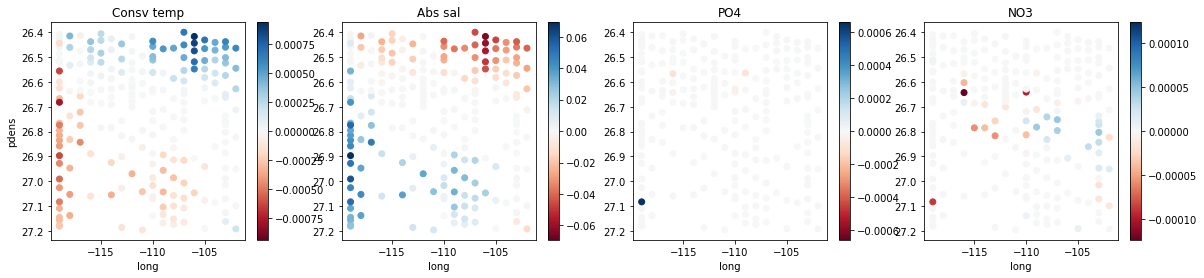

std


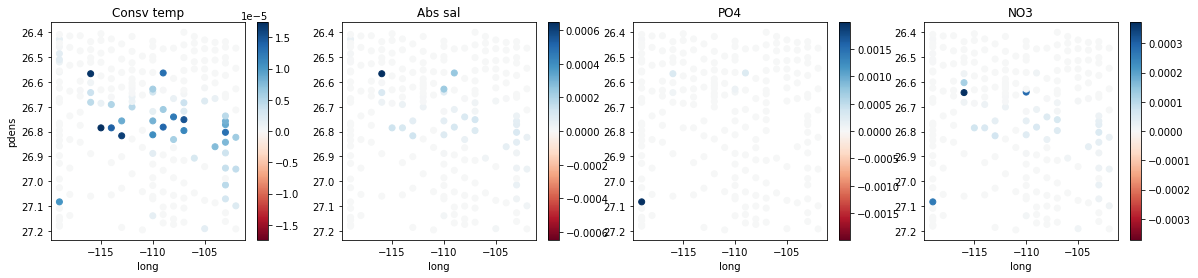

In [39]:
plot_ompasoln_residuals2(ompa_soln=mean_skeleton_endmembers,
                                  xaxis_colname="long",
                                  yaxis_colname="pdens")
print("std")
plot_ompasoln_residuals2(ompa_soln=std_skeleton_endmembers,
                                  xaxis_colname="long",
                                  yaxis_colname="pdens")

Sensitivity with regards to weightings

In [40]:
#Prepare the varying OMPA arguments

rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 20
base_weighting = paramweightings

#sample varying parameter weightings
sampled_weightings = []
for i in range(num_samples):
    rand_weighting = dict([
        (key, rng.uniform(value*0.8, value*1.2))
        for key,value in base_weighting.items()
    ])
    sampled_weightings.append(rand_weighting)

#write out the various sampled weightings
open("sampled_weightings.json", "w").write(
    json.dumps(sampled_weightings, indent=4))

varying_arguments_list = [OmpaArguments(
        constructor_arguments={"param_weightings": rand_weighting},
        solve_arguments={}) for weighting in sampled_weightings]

ETNP_weighting_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "obs_df": ETNP_df_ompasoln.obs_df,
          "endmembername_to_usagepenaltyfunc": usage_penalty,
          "param_names": ETNP_df_ompasoln.param_names,
          "convertedparam_groups": convertedparamgroups
          },
        solve_arguments={
            "endmember_df": endmembers_df,
            "endmember_name_column": "Water masses",
            "batch_size": 100
        }
    ))

!mkdir param_weightings_sensitivity
ompa_solns = ETNP_weighting_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="param_weightings_sensitivity",
    export_settings={"orig_cols_to_include":ORIG_COLS_TO_INCLUDE})


mkdir: cannot create directory ‘param_weightings_sensitivity’: File exists
On varying argument 0 out of 20
varying arguments: OMPAArguments(constructor_arguments={'param_weightings': {'Consv temp': 11.600416981452927, 'Abs sal': 8.11472532010117, 'PO4': 4.8149004398091115, 'NO3': 3.6810267292324816}}, solve_arguments={})
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['Consv temp', 'Abs sal', 'PO4', 'NO3']
param weighting: [11.60041698  8.11472532  4.81490044  3.68102673]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 100 out of 214
status: optimal
optimal value 9.545522933481575
Original weighted sum squares: 9.408135463476619
Post fix weighted sum squared: 9.408165932593226
On example 100 to 200 out of 214
status: optimal
optimal value 2.7981912079992153
Original weighted sum squares: 2.681904520778774
Post fix weighted sum squared: 2.6819397648827454
On example 200 to 300 out

mean


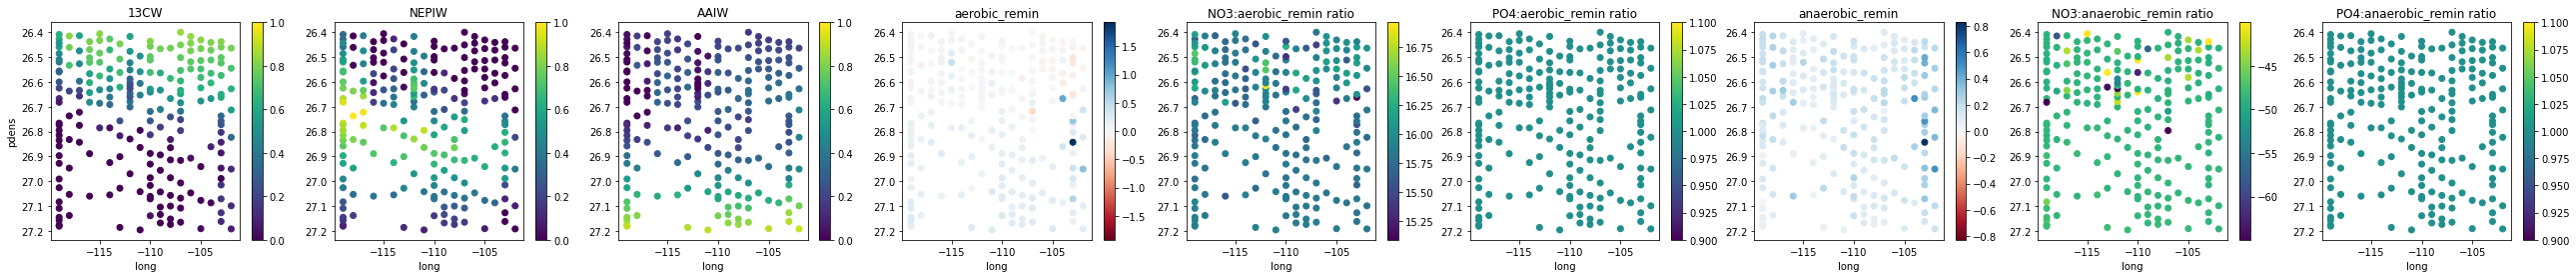

std


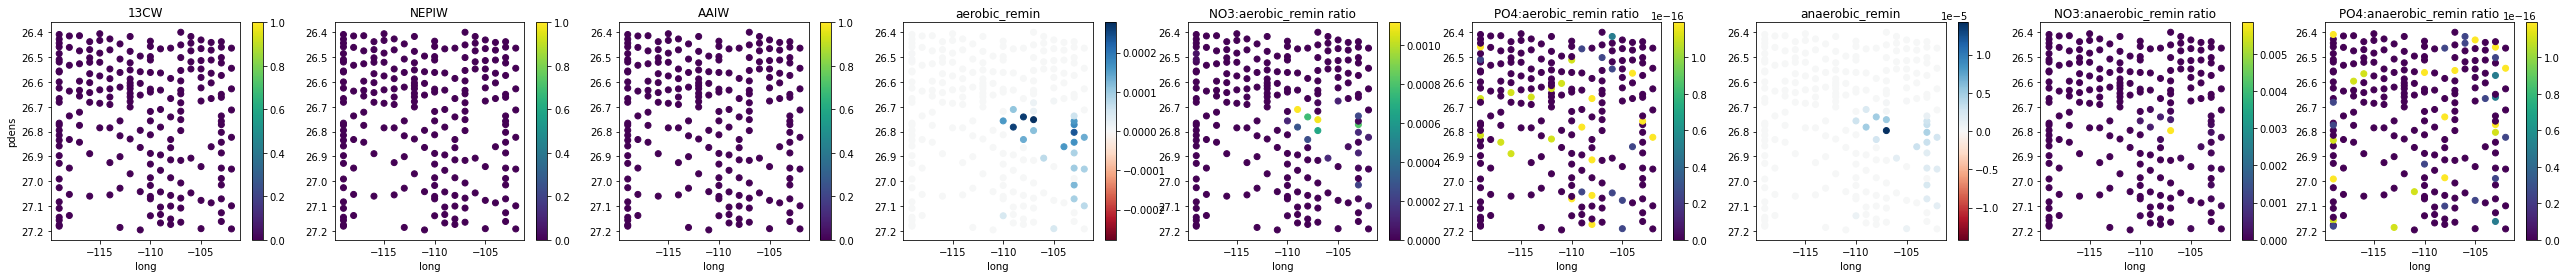

In [41]:
#plot the solutions

mean_skeleton_weightings, std_skeleton_weightings = get_mean_and_stdev_skeletons(ompa_solns=ompa_solns)

print("mean")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=mean_skeleton_weightings,
                                  xaxis_colname="long",
                                  yaxis_colname="pdens")
print("std")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=std_skeleton_weightings,
                                  xaxis_colname="long",
                                  yaxis_colname="pdens")

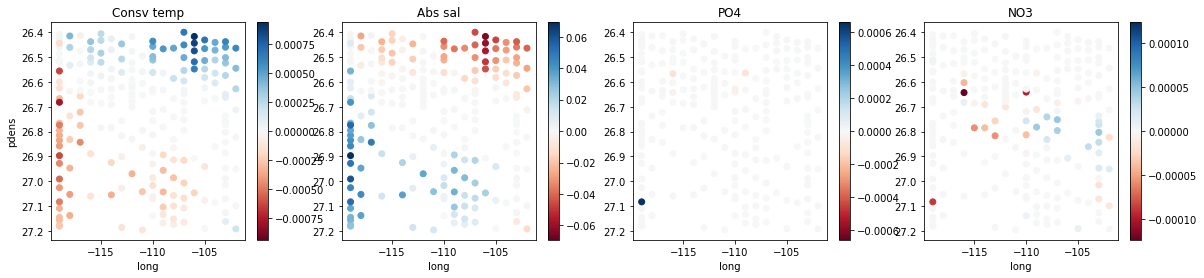

std


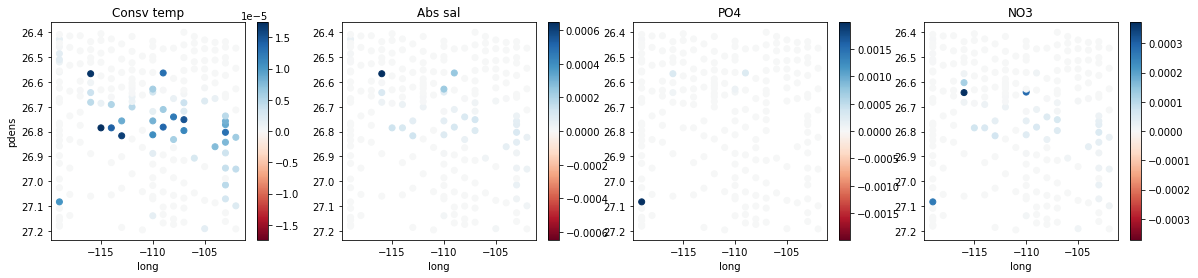

In [42]:
plot_ompasoln_residuals2(ompa_soln=mean_skeleton_endmembers,
                                  xaxis_colname="long",
                                  yaxis_colname="pdens")
print("std")
plot_ompasoln_residuals2(ompa_soln=std_skeleton_endmembers,
                                  xaxis_colname="long",
                                  yaxis_colname="pdens")

In [43]:
###uncomment below to export csv with senstivity analysis info###

%cd "/content/drive/MyDrive/pyompa/FK180624 for iodine pyompa"

ORIG_COLS_TO_INCLUDE = ORIG_COLS_TO_INCLUDE
mean_skeleton_endmembers.export_to_csv(
    csv_output_name="mean_skeleton_endmembers.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)
std_skeleton_endmembers.export_to_csv(
    csv_output_name="std_skeleton_endmembers.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

mean_skeleton_weightings.export_to_csv(
    csv_output_name="mean_skeleton_weightings.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)
std_skeleton_weightings.export_to_csv(
    csv_output_name="std_skeleton_weightings.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

/content/drive/MyDrive/pyompa/FK180624 for iodine pyompa
writing to mean_skeleton_endmembers.csv
writing to std_skeleton_endmembers.csv
writing to mean_skeleton_weightings.csv
writing to std_skeleton_weightings.csv
